Adv ML Final Project <br>
Identifying Anti-LGBTQIA-Discriminatory State Bills <br>
Carolyn Vilter <br>
23.05.21

## Data preparation and LSTM model

## LSTM Variations Edition

### Data preparation

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import time

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch import nn
import torch.nn.functional as F
from torch.utils.data.dataset import random_split

from torchtext.data.utils import get_tokenizer
from torchtext.vocab import Vectors, build_vocab_from_iterator
from torchtext.vocab import GloVe

from torchmetrics.classification import BinaryRecall
from torchmetrics.classification import BinaryPrecision
#from sklearn.metrics import confusion_matrix, roc_curve, ConfusionMatrixDisplay

#nltk.download('stopwords')
from nltk.corpus import stopwords

import math
from string import digits

In [59]:
# Combined bill text / discriminatory label datasets
df = pd.read_csv("data/ML_text_data_new.csv")

In [60]:
# Drop bills with no text
df = df[df['text'].notna()]

In [61]:
stop_words = set(stopwords.words('english'))
stop_words.update(['.', ',', '(', ')', '--', 'hba', 'sba', 'hb', 'sb', 'house', 'senate', 'session'
                   'hbb', 'sshb', '-ls\\s', '-ls\\a', 'sbb', 'cssb', 'cra', '-ls\\b', 'legislature'])
data_raw = zip(df['discriminatory'], df['text'])
data = [(label, tokens) for (label, tokens) in data_raw] 
len(data)

2660

In [62]:
# Bill text cleanup function
def clean_text(text):
    ''' 
    Clean bill text: replace incorrect delimeters and remove meaningless 
    recurring text, extra spaces, and digits
    '''
    text = text.replace("\n", " ")
    text = text.replace("New Text Underlined", "")
    text = text.replace("[DELETED TEXT BRACKETED]", "")
    text = text.replace("HOUSE BILL", "")
    text = text.replace("SENATE BILL", "")
    text = re.sub(" {2,}", " ", text)
    remove_digits = str.maketrans('', '', digits)
    text = text.translate(remove_digits)
    return text
    
# Tokenizer
tokenizer = get_tokenizer('basic_english')

In [63]:
# Tokenize bill texts; identify short/messy texts
tokenized_texts = []
min_len = float('inf')
max_len = 0
lengths = []
num_weird_bills = 0

for text in df["text"]:
    text = clean_text(text)
    text = tokenizer(text)
    text = [w for w in text if w not in stop_words]
    tokenized_texts.append(text)

    num_tokens = len(text)
    lengths.append(num_tokens)
    if num_tokens > max_len:
        max_len = num_tokens
    if num_tokens < min_len:
        min_len = num_tokens
    if num_tokens < 100:
        # print short bill texts for inspection
        #print(text)
        num_weird_bills += 1

# print key info
print("min length:", min_len, ", max length:", max_len)
print("num bills:", len(tokenized_texts), ", num weird bills:", num_weird_bills)

min length: 6 , max length: 133364
num bills: 2660 , num weird bills: 202


In [7]:
# Turn our labels and cleaned-up text into a coherent dataset (list of tuples)
data = []
for label, tokens in zip(df["discriminatory"], tokenized_texts):
    #single_string = ""
    #for token in text:
    #    single_string = single_string + token + " "
    data.append((label, tokens))
len(data)

2660

In [8]:
# # #standardize bill length - truncate and pad
# for i, (label, tokens) in enumerate(data):
#     if len(tokens) > 500:
#         tokens = tokens[:500]
#         data[i] = (label, tokens)
#     else:
#         pad_len = 500 - len(tokens)
#         padding = ['<unk>'] * pad_len
#         tokens = tokens + padding
#         data[i] = (label, tokens)

In [65]:
# standardize bill length - split and pad
def standardize_text(data_list):
    '''
    To accomodate model limitations, standardize "bill" length to 500 words.
    Bills of >500 words are split into multiple correctly-labeled sections.
    Bills and sections of <500 words are padded.
    '''
    data = []
    for i, (label, all_tokens) in enumerate(data_list):
        if len(all_tokens) > 500 and len(all_tokens) < 10000:
            num_div = math.trunc(len(all_tokens)/500)
            for i in range(num_div):
                tokens = all_tokens[i*500:(i+1)*500]
                data.append((label, tokens))
            end_tokens = all_tokens[num_div*500:]
            pad_len = 500 - len(end_tokens)
            padding = ['<unk>'] * pad_len
            end_tokens = end_tokens + padding
            data.append((label, end_tokens))
        elif len(all_tokens) < 10000:
            pad_len = 500 - len(all_tokens)
            padding = ['<unk>'] * pad_len
            tokens = all_tokens + padding
            data.append((label, tokens))

    return data

In [10]:
# Prep for data split
len_train = int(len(data) * .8)
len_valid = int((len(data) - len_train)/2)
len_test = len(data) - len_train - len_valid
print(len_train, "train", len_valid, "validation", len_test, "testing")

# Split
train_data, valid_data, test_data = random_split(
    data, [len_train, len_valid, len_test])

2128 train 266 validation 266 testing


In [11]:
# For reference, before splitting into chunks of 500:
for dataset in [train_data, valid_data, test_data]:
    print("total dataset length: ", len(dataset))
    print()
    # ex. bill lengths
    for i in range(0, 3):
        print(f"bill %s length: " %i, len(dataset[i][1]))
    print()

total dataset length:  2128

bill 0 length:  613
bill 1 length:  212
bill 2 length:  288

total dataset length:  266

bill 0 length:  17434
bill 1 length:  159
bill 2 length:  1337

total dataset length:  266

bill 0 length:  1092
bill 1 length:  94
bill 2 length:  292



In [12]:
data = standardize_text(data)
train_data = standardize_text(train_data)
valid_data = standardize_text(valid_data)
test_data = standardize_text(test_data)

In [13]:
# Now after
for dataset in [train_data, valid_data, test_data]:
    print("total dataset length: ", len(dataset))
    print()
    # ex. bill lengths
    for i in range(0, 3):
        print(f"bill %s length: " %i, len(dataset[i][1]))
    print()

total dataset length:  4925

bill 0 length:  500
bill 1 length:  500
bill 2 length:  500

total dataset length:  687

bill 0 length:  500
bill 1 length:  500
bill 2 length:  500

total dataset length:  647

bill 0 length:  500
bill 1 length:  500
bill 2 length:  500



In [14]:
# Make vocab from tokens
vocab = build_vocab_from_iterator(
  tokenized_texts, specials=["<unk>"], min_freq = 100)
vocab.set_default_index(vocab["<unk>"])
len(vocab)

3884

In [15]:
# Import glove: CHANGE DIR
# Claire
VECTOR_CACHE_DIR: str = "CAPP/Adv_ML/.vector_cache"
# Carolyn
# VECTOR_CACHE_DIR = '/Users/carolynvilter/Documents/MSCAPP_Y2Q3/adv_ml/.vector_cache'

glove = GloVe(name='6B', cache = VECTOR_CACHE_DIR)
glove_vectors = glove.get_vecs_by_tokens(vocab.get_itos())
print(f"Glove vectors tensor shape: {glove_vectors.shape}")

Glove vectors tensor shape: torch.Size([3884, 300])


In [66]:
# Prep to turn our data into custom dataset
    
class CustomDataset(Dataset):
    ''' 
    Custom dataset class for processing model-input bill data
    '''
    def __init__(self, data):
        self.data = data
        self.vocab = vocab

    def vocab_size(self):
        # add one more for out of vocab words
        return len(self.vocab) + 1
    
    def get_vocab(self):
        return self.vocab

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        label, tokenized_text = self.data[idx]
        tokenized_texts_idxs = self.vocab.lookup_indices(tokenized_text)
        return (torch.LongTensor([label]), torch.LongTensor(tokenized_texts_idxs))

### LSTM

In [67]:
# Model class
class RNNLSTM(nn.Module):
    ''' 
    RNN-LSTM Model class
    Inputs
        embed_type: 'nn' for randomly-initialized or 'glove' for GloVe embeddings
        vocab_size: size of vocabulary being used
        embedding_dim: desired dimension of embedding vector, if embed type nn
        freeze_status: True for frozen and False for non-frozen embeddings, 
            if embed type 'glove'
        hidden_dim: desired dimension of hidden layer(s)
        num_layers: desired number of hidden layers
        dropout: desired dropout rate; defaults to 0.5 per CNN findings
    Outputs
        y_hat (predictions) and hidden layer vector
    '''
    def __init__(self, embed_type, vocab_size, embedding_dim,
                 freeze_status, hidden_dim, num_layers, dropout = 0.5):
        # nn.Module init
        super(RNNLSTM, self).__init__()
        if embed_type == "nn":
            self.embedding = nn.Embedding(vocab_size, embedding_dim)
        elif embed_type == "glove":
            self.embedding = nn.Embedding.from_pretrained(glove_vectors, 
                                                        freeze=freeze_status)
        if num_layers < 2:
            dropout == 0
        self.lstm = nn.LSTM(input_size = embedding_dim, 
                            hidden_size = hidden_dim, 
                            num_layers = num_layers, 
                            dropout = dropout)
        self.linear = nn.Linear(hidden_dim, 1)

    def forward(self, input, hidden0):
        embeddings = self.embedding(input)
        output, hidden = self.lstm(embeddings, hidden0)
        y_hat = self.linear(output)
        return y_hat, hidden

In [18]:
# Evaluation function
def evaluate(model, dataloader):
    '''
    Evaluate the model on the given data.
    '''

    model.eval()
    it = iter(dataloader)
    total_count = 0. # Number of target labels seen
    total_loss = 0. # Loss over all target labels
    with torch.no_grad():
        # Default to zero (no hidden tensors in first batch)
        hidden = None 
        for i, batch in enumerate(it):
            target, text = batch
            output, hidden = model(text, hidden)
            loss = loss_fn(output, target)
            
            total_count += 1
            total_loss += loss
            
    loss = total_loss / total_count
    model.train()
    return loss

In [19]:
# Create dataloaders

BATCH_SIZE = 16

train_set = CustomDataset(train_data)
train_dataloader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)

valid_set = CustomDataset(valid_data)
valid_dataloader = DataLoader(valid_set, batch_size=BATCH_SIZE, shuffle=True)

test_set = CustomDataset(test_data)
test_dataloader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True)

In [20]:
# Examine dataloaders
for idx, (lt, tt) in enumerate(train_dataloader):
    print(idx, lt.shape, tt.shape)
    if idx == 2:
        break

0 torch.Size([16, 1]) torch.Size([16, 500])
1 torch.Size([16, 1]) torch.Size([16, 500])
2 torch.Size([16, 1]) torch.Size([16, 500])


In [21]:
# Cont.
for idx, (lt, tt) in enumerate(train_dataloader):
    print(idx, lt, tt)
    if idx == 2:
        break

0 tensor([[0],
        [0],
        [1],
        [0],
        [0],
        [0],
        [1],
        [1],
        [1],
        [1],
        [0],
        [0],
        [0],
        [0],
        [0],
        [1]]) tensor([[   0,    0,    0,  ...,   49,    6, 2814],
        [ 454,    0,   15,  ...,    0,    0,    0],
        [1137,  671,  223,  ...,    0,    0,    0],
        ...,
        [  30,   15,   31,  ...,    0,    0,  174],
        [1247,  986,  410,  ...,    0,    0,    0],
        [ 601, 3294,   22,  ...,  200,  171, 1595]])
1 tensor([[1],
        [0],
        [0],
        [1],
        [0],
        [1],
        [1],
        [1],
        [0],
        [1],
        [0],
        [0],
        [1],
        [0],
        [0],
        [1]]) tensor([[ 960,  410,  261,  ..., 2333, 1034, 3445],
        [ 162,  195,   16,  ...,   45,    1,   54],
        [   3, 2118,    0,  ...,    2, 2055,  413],
        ...,
        [ 315, 1887,  234,  ...,    0,    0,    0],
        [   3, 2118,    0,  ...

In [22]:
def get_probabilites(dataloader):
    ''' 
    Return predicted y probabilites for use in creating ROC curve 
    and confusion matrix
    '''
    model.eval()
    y_list = []
    y_pred_list = []
    with torch.no_grad(): 
        for idx, (label, word_idxs) in enumerate(dataloader):
            output, _ = model(word_idxs, hidden)
            _, predictions = torch.max(output.data, 1)
            for i, pred in enumerate(predictions):
                if pred > 1:
                    predictions[i] = 1
            y_list.append(label)
            y_pred_list.append(predictions)
    y = torch.cat(y_list, dim=0)
    y_pred = torch.cat(y_pred_list, dim=0)
    return y, y_pred

In [23]:
def get_accuracy(dataloader):
    ''' 
    Given a trained model and a (test or validation) dataloader, evaluate and
    return the accuraccy, recall, and precision of the model on the data.
    '''
        
    model.eval()
    with torch.no_grad():   
        hidden = None 
        total_acc, total_count = 0, 0
        all_recall = []
        all_precision = []
        recall_metric = BinaryRecall()
        precision_metric = BinaryPrecision()
        
        for idx, (label, word_idxs) in enumerate(dataloader):
            output, _ = model(word_idxs, hidden)
            _, predictions = torch.max(output.data, 1)
            for i, pred in enumerate(predictions):
                if pred > 1:
                    predictions[i] = 1

            total_acc += (predictions == label).sum().item()
            total_count += label.size(0)

            if idx < 122:
                recall = recall_metric(predictions, label)
                precision = precision_metric(predictions, label)
                all_recall.append(recall)
                all_precision.append(precision)

    accuracy = total_acc/total_count

    return accuracy, np.mean(all_recall), np.mean(all_precision)

### Variation 1: Glove Embeddings, Freeze = True

In [24]:
# Prep to train
GRAD_CLIP = 1.
NUM_EPOCHS = 10 
EMBED_TYPE = "glove"
EMBEDDING_SIZE = glove_vectors.shape[1]
FREEZE_STATUS = True
NUM_LAYERS = 2
LR = 0.0005
VOCAB_SIZE = len(vocab)
loss_fn = nn.CrossEntropyLoss()

model = RNNLSTM(EMBED_TYPE, VOCAB_SIZE, EMBEDDING_SIZE, FREEZE_STATUS,
                EMBEDDING_SIZE, NUM_LAYERS)

optimizer = torch.optim.Adam(model.parameters(), lr = LR)
val_losses = []

def repackage_hidden(h):
    """Wraps hidden states in new Tensors, to detach them from their history."""
    if h is None:
        return None
    elif isinstance(h, torch.Tensor):
        return h.detach()
    else:
        return tuple(repackage_hidden(v) for v in h)
    
# Store metrics
accuracies_val = []
recalls_val = []
precisions_val = []
accuracies_train = []
recalls_train = []
precisions_train = []

At iteration 60 the loss is 1.376.
At iteration 120 the loss is 3.296.
At iteration 180 the loss is 4.322.
At iteration 240 the loss is 5.642.
At iteration 300 the loss is 1.369.
Epoch 0 - validation accuracy: 0.438, 
            recall: 0.9246954917907715, precision: 0.41740620136260986.
At iteration 60 the loss is 2.225.
At iteration 120 the loss is 0.573.
At iteration 180 the loss is 0.667.
At iteration 240 the loss is 0.684.
At iteration 300 the loss is 0.704.
Epoch 1 - validation accuracy: 0.461, 
            recall: 0.8919434547424316, precision: 0.4245712459087372.
At iteration 60 the loss is 0.700.
At iteration 120 the loss is 0.762.
At iteration 180 the loss is 0.635.
At iteration 240 the loss is 2.399.
At iteration 300 the loss is 0.745.
Epoch 2 - validation accuracy: 0.448, 
            recall: 0.9733572602272034, precision: 0.42210298776626587.
At iteration 60 the loss is 1.060.
At iteration 120 the loss is 0.835.
At iteration 180 the loss is 0.873.
At iteration 240 the los

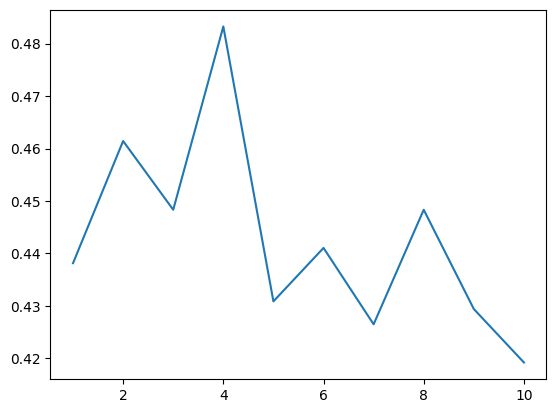

In [25]:
# Train model
for epoch in range(NUM_EPOCHS):

    # 1: Train the epoch
    model.train()
    it = iter(train_dataloader)
    # default to zeros (no hidden tensors for the first batch)
    hidden = None
    for i, batch in enumerate(it):       
        # extract text and target
        target, text = batch
        # pass detached hidden state vector
        # call forward prop to get output and final hidden state
        output, hidden = model(text, repackage_hidden(hidden))
        # zero out gradients
        optimizer.zero_grad()
        # compute loss
        loss = loss_fn(output, target)
        # run backprop
        loss.backward()
        # clip gradients that may have exploded
        nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP)
        # run a step of gradient descent
        optimizer.step()
        # print batch loss after every few iterations
        print_interval = 60
        if i % print_interval == 0 and i > 0:
            print(f'At iteration {i} the loss is {loss:.3f}.')
        # evaluate on validation set after every 10,000 iterations and save
        if i % 100 == 0 and i > 0:
            val_loss = evaluate(model, valid_dataloader)
            val_losses.append(val_loss)
    
    # 2: Evaluate results
    accuracy_val, recall_val, precision_val = get_accuracy(valid_dataloader)
    accuracy_train, recall_train, precision_train = get_accuracy(train_dataloader)
    accuracies_val.append(accuracy_val)
    recalls_val.append(recall_val)
    precisions_val.append(precision_val)
    accuracies_train.append(accuracy_train)
    recalls_train.append(recall_train)
    precisions_train.append(precision_train)
    print(f'''Epoch {epoch} - validation accuracy: {accuracy_val:.3f}, 
            recall: {recall_val}, precision: {precision_val}.''')

plt.plot(range(1, NUM_EPOCHS+1), accuracies_val)

accuracy, recall, precision = get_accuracy(test_dataloader)
y, y_prob = get_probabilites(test_dataloader)
print(f'The estimated test accuracy is {accuracy:.3f}, recall {recall}, precision {precision}.')

In [26]:
metrics = ["Training accuracies, recalls, and precisions", accuracies_train, recalls_train, precisions_train, "Validation accuracies, recalls, and precisions", accuracies_val, recalls_val, precisions_val]
for item in metrics:
    print(item)

Training accuracies, recalls, and precisions
[0.45076142131979696, 0.46436548223350255, 0.4505583756345178, 0.4739086294416244, 0.4584771573604061, 0.4586802030456853, 0.45563451776649744, 0.45989847715736043, 0.4450761421319797, 0.449746192893401]
[0.7540697, 0.7901835, 0.91353756, 0.8099076, 0.8927353, 0.8151639, 0.85961163, 0.9154108, 0.89697176, 0.87974566]
[0.41320977, 0.40621585, 0.40409496, 0.40857804, 0.4191943, 0.3826544, 0.39535522, 0.41948453, 0.41556695, 0.41494521]
Validation accuracies, recalls, and precisions
[0.438136826783115, 0.46142649199417757, 0.4483260553129549, 0.48326055312954874, 0.43085880640465796, 0.4410480349344978, 0.4264919941775837, 0.4483260553129549, 0.4294032023289665, 0.4192139737991266]
[0.9246955, 0.89194345, 0.97335726, 0.9099944, 0.9153931, 0.940993, 0.8990586, 0.92461234, 0.9326873, 0.9689923]
[0.4174062, 0.42457125, 0.422103, 0.43171984, 0.42352912, 0.4163596, 0.41391972, 0.42974508, 0.41665494, 0.41078812]


In [27]:
# Evaluating on the test dataset
accuracy, recall, precision = get_accuracy(test_dataloader)
y, y_prob = get_probabilites(test_dataloader)
print(f'The estimated test accuracy is {accuracy:.3f}, recall {recall}, precision {precision}.')

The estimated test accuracy is 0.411, recall 0.9175958633422852, precision 0.359361469745636.


Accuracy

Text(0, 0.5, 'Accuracy')

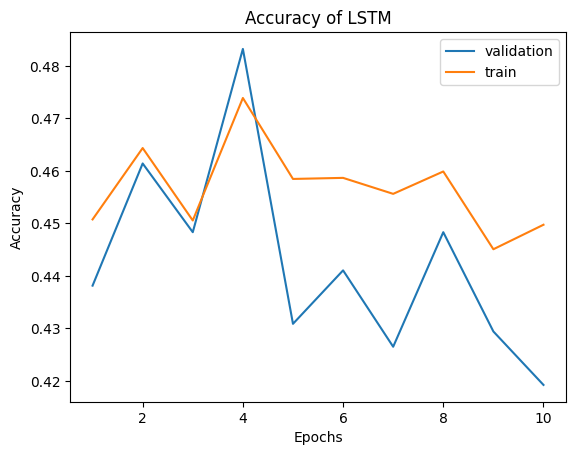

In [28]:
plt.plot(range(1, NUM_EPOCHS+1), accuracies_val, label='validation')
plt.plot(range(1, NUM_EPOCHS+1), accuracies_train, label='train')
plt.title('Accuracy of LSTM')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')


Recall

Text(0, 0.5, 'Recall')

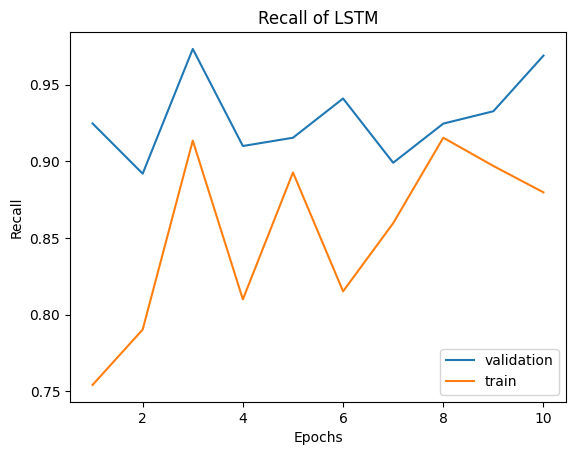

In [29]:
plt.plot(range(1, NUM_EPOCHS+1), recalls_val, label='validation')
plt.plot(range(1, NUM_EPOCHS+1), recalls_train, label='train')
plt.title('Recall of LSTM')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Recall')


Precision

Text(0, 0.5, 'Precision')

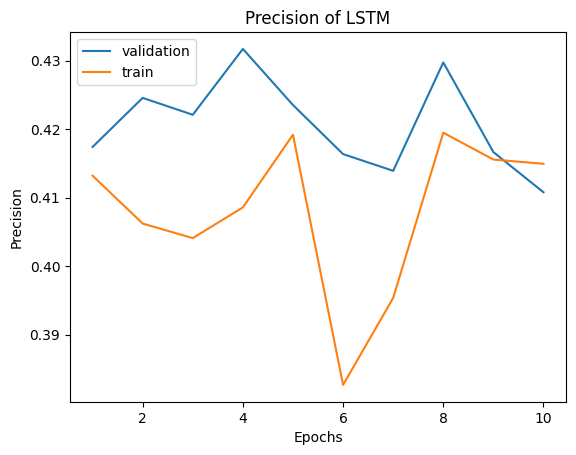

In [30]:
plt.plot(range(1, NUM_EPOCHS+1), precisions_val, label='validation')
plt.plot(range(1, NUM_EPOCHS+1), precisions_train, label='train')
plt.title('Precision of LSTM')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Precision')


ROC

In [31]:
y, y_prob = get_probabilites(test_dataloader)

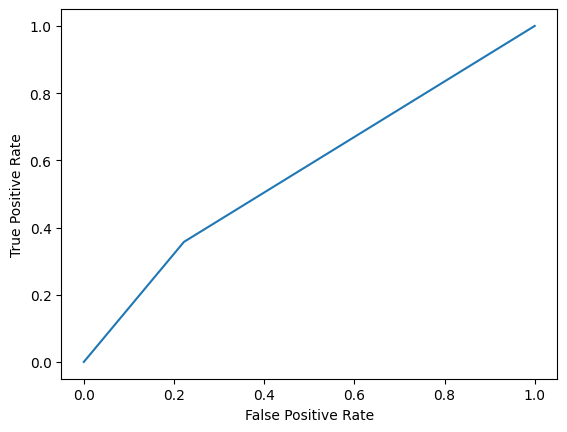

In [32]:
def plot_roc_curve(true_y, y_prob):
    """
    plots the roc curve based of the probabilities
    """

    fpr, tpr, thresholds = roc_curve(true_y, y_prob)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

plot_roc_curve(y, y_prob)

Confusion

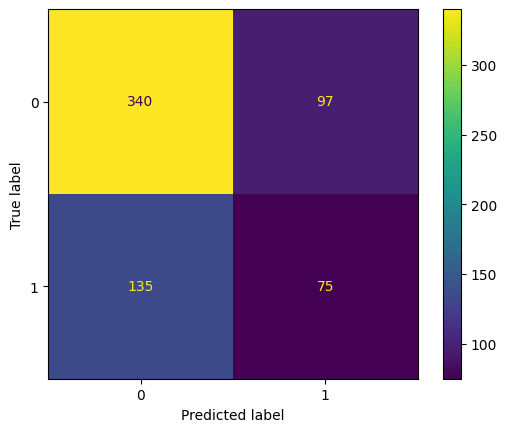

In [33]:
cf_mat = confusion_matrix(y, y_prob)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_mat)
disp.plot()
plt.show()

### Variation 2: Glove Embeddings, Freeze = False

In [37]:
# Prep to train
GRAD_CLIP = 1.
NUM_EPOCHS = 10 
EMBED_TYPE = "glove"
EMBEDDING_SIZE = glove_vectors.shape[1]
FREEZE_STATUS = False
NUM_LAYERS = 2
LR = 0.0005
VOCAB_SIZE = len(vocab)
loss_fn = nn.CrossEntropyLoss()

model = RNNLSTM(EMBED_TYPE, VOCAB_SIZE, EMBEDDING_SIZE, FREEZE_STATUS,
                EMBEDDING_SIZE, NUM_LAYERS)

optimizer = torch.optim.Adam(model.parameters(), lr = LR)
val_losses = []

def repackage_hidden(h):
    """Wraps hidden states in new Tensors, to detach them from their history."""
    if h is None:
        return None
    elif isinstance(h, torch.Tensor):
        return h.detach()
    else:
        return tuple(repackage_hidden(v) for v in h)
    
# Store metrics
accuracies_val = []
recalls_val = []
precisions_val = []
accuracies_train = []
recalls_train = []
precisions_train = []

At iteration 60 the loss is 1.099.
At iteration 120 the loss is 0.653.
At iteration 180 the loss is 0.679.
At iteration 240 the loss is 0.689.
At iteration 300 the loss is 0.660.
Epoch 0 - validation accuracy: 0.460, 
            recall: 0.8594222664833069, precision: 0.4232967793941498.
At iteration 60 the loss is 0.735.
At iteration 120 the loss is 4.136.
At iteration 180 the loss is 2.056.
At iteration 240 the loss is 0.658.
At iteration 300 the loss is 1.694.
Epoch 1 - validation accuracy: 0.444, 
            recall: 0.9013381600379944, precision: 0.41475921869277954.
At iteration 60 the loss is 1.454.
At iteration 120 the loss is 0.589.
At iteration 180 the loss is 0.678.
At iteration 240 the loss is 0.610.
At iteration 300 the loss is 0.752.
Epoch 2 - validation accuracy: 0.485, 
            recall: 0.7865448594093323, precision: 0.39154505729675293.
At iteration 60 the loss is 1.049.
At iteration 120 the loss is 0.629.
At iteration 180 the loss is 0.606.
At iteration 240 the los

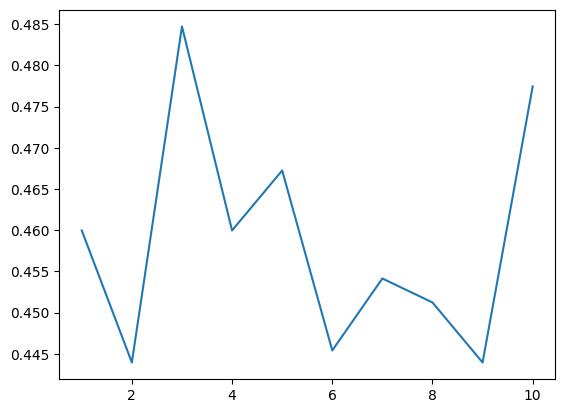

In [38]:
# Train model
for epoch in range(NUM_EPOCHS):

    # 1: Train the epoch
    model.train()
    it = iter(train_dataloader)
    # default to zeros (no hidden tensors for the first batch)
    hidden = None
    for i, batch in enumerate(it):       
        # extract text and target
        target, text = batch
        # pass detached hidden state vector
        # call forward prop to get output and final hidden state
        output, hidden = model(text, repackage_hidden(hidden))
        # zero out gradients
        optimizer.zero_grad()
        # compute loss
        loss = loss_fn(output, target)
        # run backprop
        loss.backward()
        # clip gradients that may have exploded
        nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP)
        # run a step of gradient descent
        optimizer.step()
        # print batch loss after every few iterations
        print_interval = 60
        if i % print_interval == 0 and i > 0:
            print(f'At iteration {i} the loss is {loss:.3f}.')
        # evaluate on validation set after every 10,000 iterations and save
        if i % 100 == 0 and i > 0:
            val_loss = evaluate(model, valid_dataloader)
            val_losses.append(val_loss)
    
    # 2: Evaluate results
    accuracy_val, recall_val, precision_val = get_accuracy(valid_dataloader)
    accuracy_train, recall_train, precision_train = get_accuracy(train_dataloader)
    accuracies_val.append(accuracy_val)
    recalls_val.append(recall_val)
    precisions_val.append(precision_val)
    accuracies_train.append(accuracy_train)
    recalls_train.append(recall_train)
    precisions_train.append(precision_train)
    print(f'''Epoch {epoch} - validation accuracy: {accuracy_val:.3f}, 
            recall: {recall_val}, precision: {precision_val}.''')

plt.plot(range(1, NUM_EPOCHS+1), accuracies_val)

accuracy, recall, precision = get_accuracy(test_dataloader)
y, y_prob = get_probabilites(test_dataloader)
print(f'The estimated test accuracy is {accuracy:.3f}, recall {recall}, precision {precision}.')

In [39]:
metrics = ["Training accuracies, recalls, and precisions", accuracies_train, recalls_train, precisions_train, "Validation accuracies, recalls, and precisions", accuracies_val, recalls_val, precisions_val]
for item in metrics:
    print(item)

Training accuracies, recalls, and precisions
[0.4998984771573604, 0.49441624365482234, 0.4887309644670051, 0.4789847715736041, 0.49441624365482234, 0.49908629441624364, 0.5063959390862944, 0.5041624365482233, 0.5151269035532995, 0.5100507614213198]
[0.7592503, 0.81690323, 0.7232129, 0.8939045, 0.80322665, 0.7938196, 0.7810564, 0.74276936, 0.8049245, 0.8051202]
[0.42266923, 0.44620675, 0.403598, 0.43703178, 0.44504118, 0.3846517, 0.44629338, 0.4424898, 0.43845686, 0.44151196]
Validation accuracies, recalls, and precisions
[0.45997088791848617, 0.44395924308588064, 0.4847161572052402, 0.45997088791848617, 0.4672489082969432, 0.44541484716157204, 0.45414847161572053, 0.4512372634643377, 0.44395924308588064, 0.4774381368267831]
[0.85942227, 0.90133816, 0.78654486, 0.88478214, 0.83513284, 0.8757475, 0.80757654, 0.84604096, 0.8226744, 0.86709106]
[0.42329678, 0.41475922, 0.39154506, 0.43231916, 0.41902095, 0.41018647, 0.4039888, 0.446166, 0.395113, 0.42528555]


In [40]:
# Evaluating on the test dataset
accuracy, recall, precision = get_accuracy(test_dataloader)
y, y_prob = get_probabilites(test_dataloader)
print(f'The estimated test accuracy is {accuracy:.3f}, recall {recall}, precision {precision}.')

The estimated test accuracy is 0.388, recall 0.8767130970954895, precision 0.34341657161712646.


Accuracy

Text(0, 0.5, 'Accuracy')

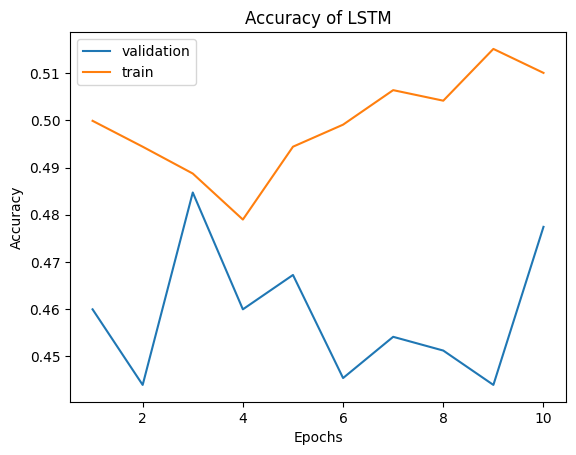

In [41]:
plt.plot(range(1, NUM_EPOCHS+1), accuracies_val, label='validation')
plt.plot(range(1, NUM_EPOCHS+1), accuracies_train, label='train')
plt.title('Accuracy of LSTM')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')


Recall

Text(0, 0.5, 'Recall')

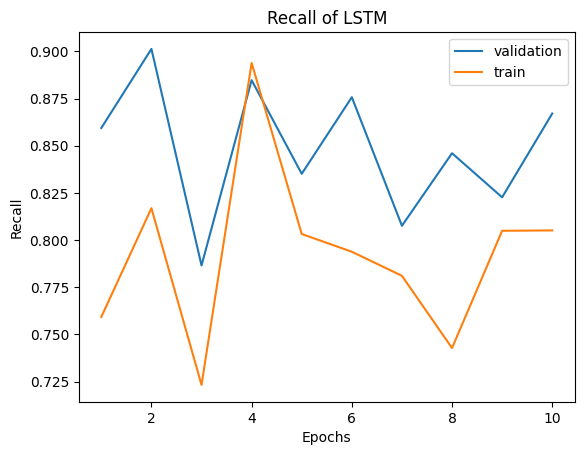

In [42]:
plt.plot(range(1, NUM_EPOCHS+1), recalls_val, label='validation')
plt.plot(range(1, NUM_EPOCHS+1), recalls_train, label='train')
plt.title('Recall of LSTM')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Recall')


Precision

Text(0, 0.5, 'Precision')

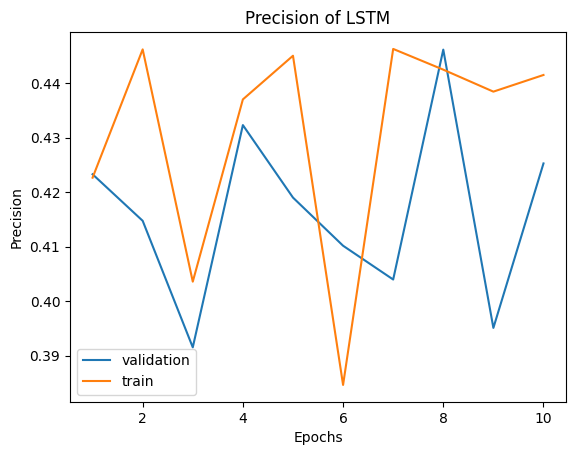

In [43]:
plt.plot(range(1, NUM_EPOCHS+1), precisions_val, label='validation')
plt.plot(range(1, NUM_EPOCHS+1), precisions_train, label='train')
plt.title('Precision of LSTM')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Precision')


ROC

In [44]:
y, y_prob = get_probabilites(test_dataloader)

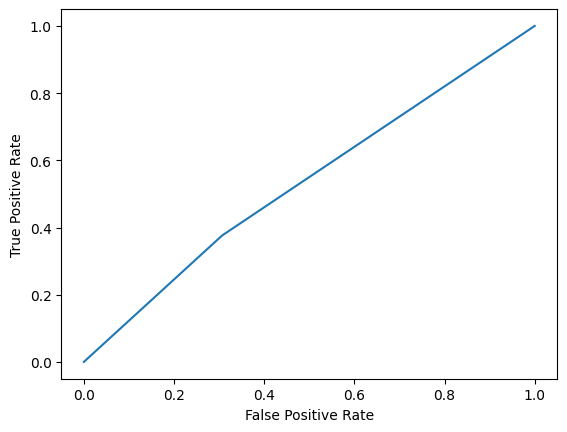

In [45]:
def plot_roc_curve(true_y, y_prob):
    """
    plots the roc curve based of the probabilities
    """

    fpr, tpr, thresholds = roc_curve(true_y, y_prob)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

plot_roc_curve(y, y_prob)

Confusion

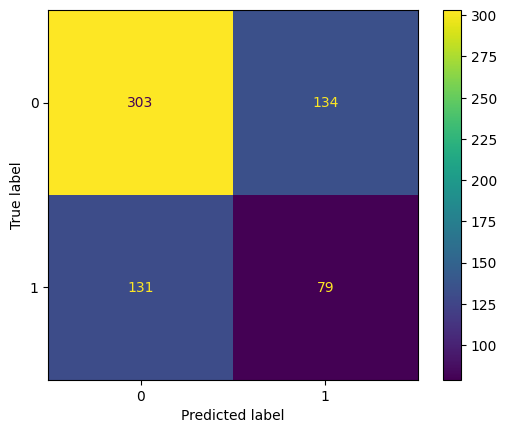

In [46]:
cf_mat = confusion_matrix(y, y_prob)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_mat)
disp.plot()
plt.show()